A medida de correlacao para essa base deve ser diferente. Primeiro que as turbinas ficam bem próximas. Segundo que velocidade do vento e geração de energia ocorrem a valores similares.

A ideia nesse caso seria plotar uma tabela de correlação entre as turbinas e um histograma de correlação cruzada entre duas delas. Citar tambem o trabalho "Forecasting wind speed with recurrent neural networks" de Qing Cao
Citar tambem o trabalho do Kusiak - "Estimation of wind speed: A data-driven approach"

1 - Carregar os dados

2 - Observar medias e desvios padrao para geracao de energia e velocidade do vento. Esoclher o de maior variaçao

3 - Calcular correlacao cruzada Pearson entre todas as turbinas

4 - Fazer calculo time-lagged para turbinas mais correlacionadas

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Leitura dos Dados

In [3]:
wind_file = '/Users/cseveriano/spatio-temporal-forecasting/data/raw/WindFarm-RN/HISTORICO.xlsx'

In [4]:
df = pd.read_excel(wind_file, index_col=0)

In [5]:
#conversao para float, porque o valor lido originalmente é object
for col in df.columns:
    df[col] = df[col].convert_objects(convert_numeric=True)

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
wind_power_df = df.iloc[:,0:15]
wind_speed_df = df.iloc[:,15:30]
wind_direction_df = df.iloc[:,30:45]



In [7]:
# Muitos NaN na base (cerca de 2000 em 52000). Como a irregularidade da serie nao esta ligada diretamente ao ciclo diario, os dados serao removidos
wind_power_df.dropna(inplace=True)
wind_speed_df.dropna(inplace=True)
wind_direction_df.dropna(inplace=True)

In [7]:
wind_power_df.columns = ['WTG01_Power','WTG02_Power','WTG03_Power','WTG04_Power','WTG05_Power','WTG06_Power','WTG07_Power','WTG08_Power','WTG09_Power','WTG10_Power','WTG11_Power','WTG12_Power','WTG13_Power','WTG24_Power','WTG25_Power']
wind_speed_df.columns = ['WTG01_Speed','WTG02_Speed','WTG03_Speed','WTG04_Speed','WTG05_Speed','WTG06_Speed','WTG07_Speed','WTG08_Speed','WTG09_Speed','WTG10_Speed','WTG11_Speed','WTG12_Speed','WTG13_Speed','WTG24_Speed','WTG25_Speed']
wind_direction_df.columns = ['WTG01_Dir','WTG02_Dir','WTG03_Dir','WTG04_Dir','WTG05_Dir','WTG06_Dir','WTG07_Dir','WTG08_Dir','WTG09_Dir','WTG10_Dir','WTG11_Dir','WTG12_Dir','WTG13_Dir','WTG24_Dir','WTG25_Dir']



In [11]:
wind_total_df = pd.concat([wind_power_df, wind_speed_df, wind_direction_df], axis=1)

In [13]:
wind_total_df.dropna(inplace=True)

In [14]:
wind_total_df.to_pickle("df_wind_total.pkl")

## Correlation Map

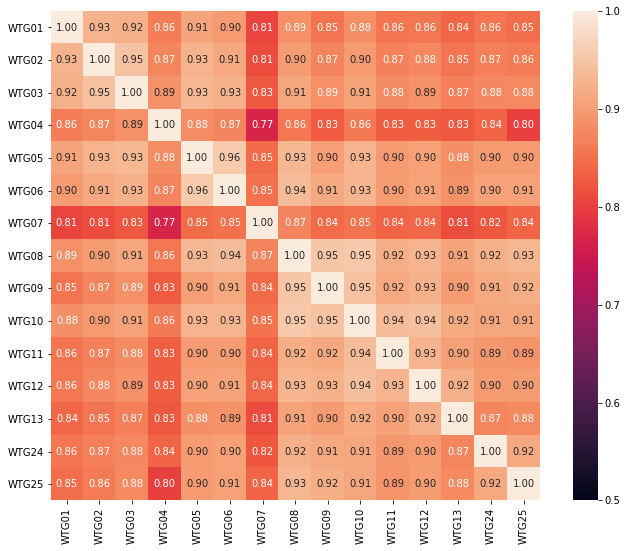

In [141]:
#correlation matrix
corrmat = wind_power_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', vmin=.5)

## Time Lagged Correlation

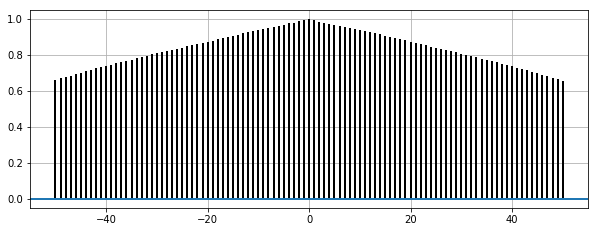

In [142]:
import datetime
y_obs_1 = wind_speed_df[wind_speed_df.index.date == datetime.date(2017, 5, 3)].WTG01
y_obs_2 = wind_speed_df[wind_speed_df.index.date == datetime.date(2017, 5, 3)].WTG02

fig = plt.figure()
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.xcorr(y_obs_1, y_obs_2, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)
#ax1.axhline(0, color='black', lw=2)

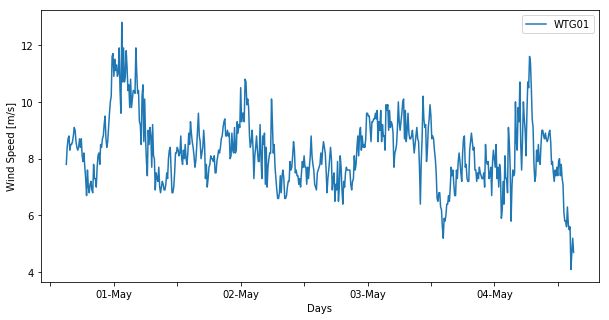

In [80]:
y_obs_4 = wind_speed_df[(wind_speed_df.index >= '2017-05-01') & (wind_speed_df.index <= '2017-05-05')].WTG01
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs_4)
ax.set_xlabel('Days')
ax.set_ylabel('Wind Speed [m/s]')
ax.legend(loc='best')
ax.set_xticklabels(['','01-May','','02-May','','03-May','','04-May'])
plt.show()

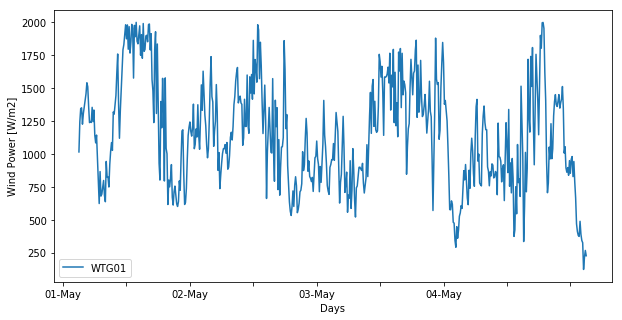

In [76]:
y_obs_4 = wind_power_df[(wind_power_df.index >= '2017-05-01') & (wind_power_df.index <= '2017-05-05')].WTG01
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(y_obs_4)
ax.set_xlabel('Days')
ax.set_ylabel('Wind Power [W/m2]')
ax.legend(loc='best')
#ax.set_xticks(['08:00','12:00','16:00','20:00'])
ax.set_xticklabels(['01-May','','02-May','','03-May','','04-May'])
plt.show()

## SSA Decomposition

In [12]:
import sys
sys.path.insert(0,"../src/ext-libraries/SingularSpectrumAnalysis/")
from mySSA import mySSA

In [13]:
df_ssa = wind_speed_df

In [32]:
dt = []
limit = 1
p_inds = [i for i in range(limit)]
df_clean = pd.DataFrame(columns=df_ssa.columns)
df_residual = pd.DataFrame(columns=df_ssa.columns)

chunk_size = 1000
indexes = np.arange(chunk_size,len(df_ssa), chunk_size)

for c in df_ssa.columns:
    dfc = df_ssa[c]
    cl = []
    rs = []
    
    start_ind = 0
    
    for stop_ind in indexes:
        
        ts = dfc[start_ind : stop_ind]
        
        N = int(len(ts)) # number of samples
        T = 144 # sample daily frequency (6 samples per hour)
        embedding_dimension =  int(N / T)
        ssa = mySSA(ts)
        ssa.embed(embedding_dimension=embedding_dimension,verbose=True)
        res_streams = [j for j in range(limit,embedding_dimension)]
        ssa.decompose(verbose=True)
        principal = ssa.view_reconstruction(*[ssa.Xs[i] for i in p_inds], names=p_inds, plot=False, return_df=True)
        residual = ssa.view_reconstruction(*[ssa.Xs[i] for i in res_streams], names=res_streams, plot=False, return_df=True)
        
        cl.extend(list(principal['Reconstruction']))
        rs.extend(list(residual['Reconstruction']))
        
        start_ind = stop_ind
        
    print("Clean sequence length for ",c," = ",len(cl))
    df_clean[c] = cl
    df_residual[c] = rs

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  6
Trajectory dimensions	: (6, 995)
Complete dimension	: (6, 995)
Missing dimension     	: (6, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 6
Dimension of projection space	: 6
Characteristic of projection	: 1.0
----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  6
Trajectory dimensions	: (6, 995)
Complete dimension	: (6, 995)
Missing dimension     	: (6, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 6
Dimension of projection space	: 6
Characteristic of projection	: 1.0
----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  6
Trajectory dimensions	: (6, 995)
Complete dimension	: (6, 995)
Missing dimension     	: (6, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 6
Dimension of projection space	: 6
Characteristic of projec

In [43]:
df_clean.index = df_ssa.index[0:50000]
df_residual.index = df_ssa.index[0:50000]
df_ssa[0:50000].to_pickle("df_wind_speed.pkl")
df_clean.to_pickle("df_wind_speed_ssa_clean.pkl")
df_residual.to_pickle("df_wind_speed_ssa_residual.pkl")

## Comparativo Original SSA

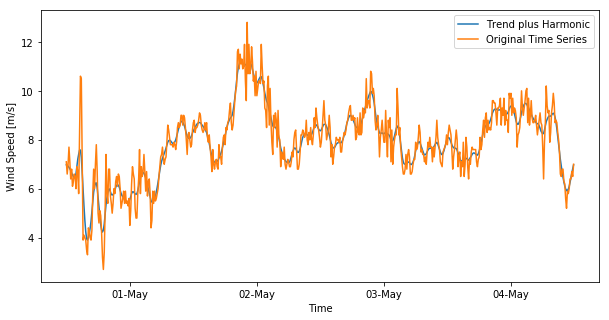

In [33]:
y_clean_wind = df_clean[0:576].WTG01
y_obs_wind = df_ssa[0:576].WTG01

#x_date = pd.date_range("00:00", "24:00", freq="10min").strftime('%H:%M')

#xn = np.arange(len(x_date))
xn = np.arange(0,576)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(xn, y_clean_wind.values, label='Trend plus Harmonic')
plt.plot(xn, y_obs_wind.values, label='Original Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Wind Speed [m/s]')
ax.legend(loc='best')
ticks = [72,216,360,504]
ax.set_xticks(ticks)
#ax.set_xticklabels(x_date[ticks])
ax.set_xticklabels(['01-May','02-May','03-May','04-May'])
plt.show()

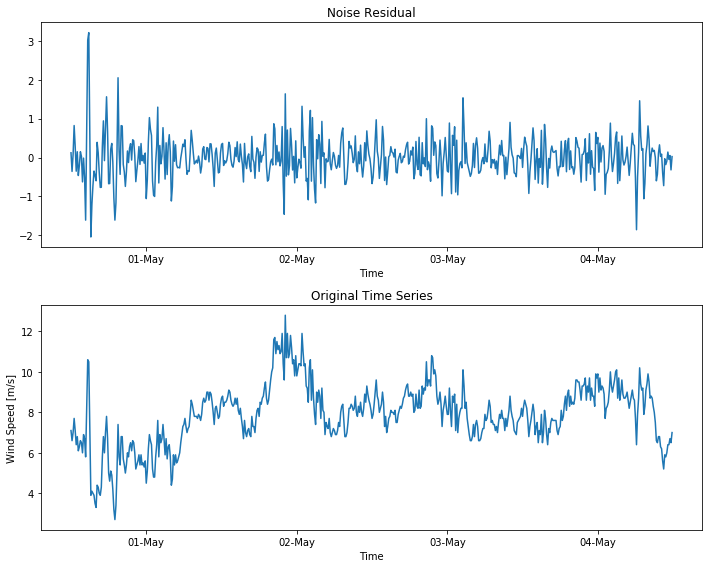

In [34]:
y_residual_wind = df_residual[0:576].WTG01

xn = np.arange(0,576)

fig = plt.figure(figsize=(10,8))

# Serie Residuo
ax = fig.add_subplot(211)
plt.plot(xn, y_residual_wind.values)
ax.set_xlabel('Time')
ax.set_title('Noise Residual')
#ax.legend(loc='best')
ticks = [72,216,360,504]
ax.set_xticks(ticks)
ax.set_xticklabels(['01-May','02-May','03-May','04-May'])

# Serie Original
ax2 = fig.add_subplot(212)
plt.plot(xn, y_obs_wind.values)
ax2.set_xlabel('Time')
ax2.set_ylabel('Wind Speed [m/s]')
ax2.set_title('Original Time Series')
#ax2.legend(loc='best')
ticks = [72,216,360,504]
ax2.set_xticks(ticks)
ax2.set_xticklabels(['01-May','02-May','03-May','04-May'])

fig.tight_layout() 
plt.show()

## ACF and PACF Plots

In [3]:
#Set target and input variables 
target_station = 'WTG01'

df = pd.read_pickle("df_wind_speed.pkl")
df_ssa_clean = pd.read_pickle("df_wind_speed_ssa_clean.pkl")
df_ssa_residual = pd.read_pickle("df_wind_speed_ssa_residual.pkl")

# Get data form the interval of interest
interval = ((df.index >= '2017-05') & (df.index <= '2018-05'))
df = df.loc[interval]
df_ssa_clean = df_ssa_clean.loc[interval]
df_ssa_residual = df_ssa_residual.loc[interval]

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\cseve\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
import datetime

In [8]:
pivot = df.index[0]
start = pivot.strftime('%Y-%m-%d')
pivot = pivot + datetime.timedelta(days=34)
end = pivot.strftime('%Y-%m-%d')

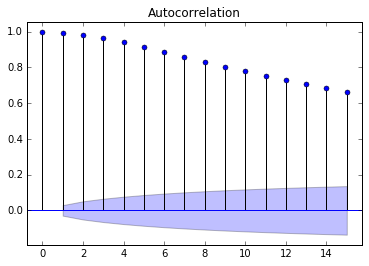

In [11]:
fig = plot_acf(df_ssa_clean[start:end][target_station].values, lags=15)
fig.savefig("acf_wind_clean.png")

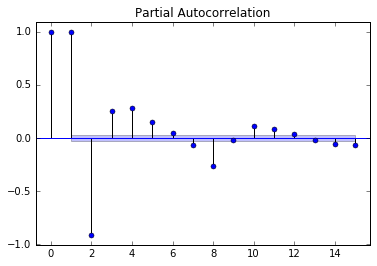

In [12]:
fig = plot_pacf(df_ssa_clean[start:end][target_station].values, lags=15)
fig.savefig("pacf_wind_clean.png")

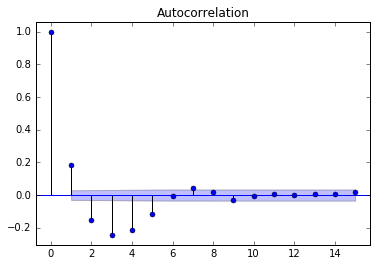

In [13]:
fig = plot_acf(df_ssa_residual[start:end][target_station].values, lags=15)
fig.savefig("acf_wind_residual.png")

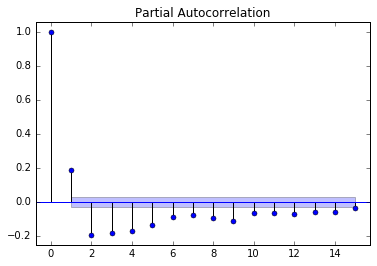

In [14]:
plot_pacf(df_ssa_residual[start:end][target_station].values, lags=15)
fig.savefig("pacf_wind_residual.png")

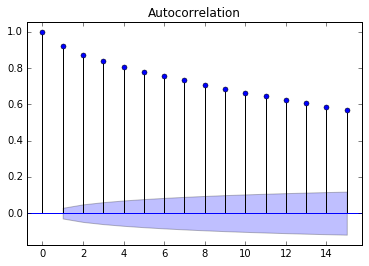

In [15]:
fig = plot_acf(df[start:end][target_station].values, lags=15)
fig.savefig("acf_wind_raw.png")

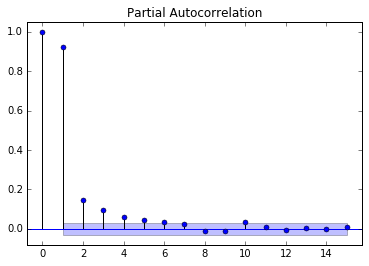

In [16]:
fig = plot_pacf(df[start:end][target_station].values, lags=15)
fig.savefig("pacf_wind_raw.png")

## Correlation Map after SSA Decomposition

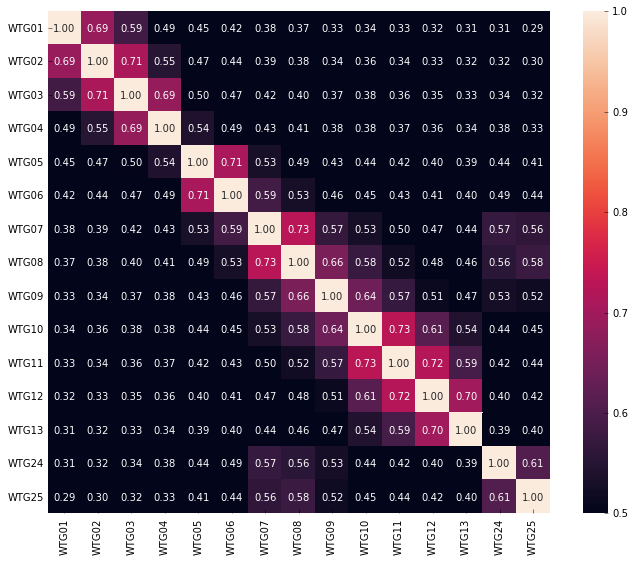

In [24]:
#correlation matrix
corrmat = df_ssa_residual.corr()
f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', vmin=.5)